# Projekt 2 - klasteryzacja
## Temat 3 - Text classification Documentation

Poprawki wprowadzone do projektu po uwzględnieniu uwag zespołu walidującego zostały dodane kolorem <span style="color: purple;">fioletowym</span>.

### Plan projektu

0. <span style="color: purple;">Podział danych</span>
1. Wstęp
2. Wczytanie danych i wstępne informacje

    2.1. Cel biznesowy
    
3. Czyszczenie danych

    3.1. Duplikaty i brakujące wartości
    
    3.2. Stopwords i inne fragmenty nieistotne semantycznie

4. Wizualizacja danych

    4.1. wordcloud

    4.2. plotly

    4.3. scattertext
   
    4.4. <span style="color: purple;">Analiza par i trójek słów</span>

5. Wnioski

### <span style="color: purple;">0. Podział danych</span>

<span style="color: purple;">Poniżej znajduje się kod, który pozwoli na podział danych na zbiory treningowy, testowy i walidacyjny. Następnie zostały one zapisane do plików .csv, aby móc je wykorzystać w dalszej części projektu.</span>

In [ ]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# df = pd.read_csv('df_file.csv')
# X = df.iloc[:, 0]
# y = df.iloc[:, 1]
# X_our, X_valid, y_our, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X_our, y_our, test_size=0.3, random_state=42)
# X_train.to_csv('X_train.csv', index=False)
# X_test.to_csv('X_test.csv', index=False)
# y_train.to_csv('y_train.csv', index=False)
# y_test.to_csv('y_test.csv', index=False)
# X_valid.to_csv('X_valid.csv', index=False)
# y_valid.to_csv('y_valid.csv', index=False)

### 1. Wstęp

Celem niniejszego projektu jest przeprowadzenie analizy zawartości dokumentów, ze szczególnym uwzględnieniem rozkładu słów i tematów. Zacznijmy od wczytania potrzebnych pakietów i bibliotek:

In [ ]:
# pip install pillow
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')
# pip install wordcloud
# pip install scattertext

import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.colors as mcolors
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import re
import plotly.express as px
# import scattertext as st
# import spacy
# spacy.load('en_core_web_sm')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


### 2. Wczytanie danych i wstępne informacje

Zacznijmy od wczytania danych pobranych ze strony kaggle.com.

Są to fragmenty wiadomości z portalu BBC, pochodzące z lat 2004-2005.

#### 2.1. Cel biznesowy

Celem biznesowym naszego projektu jest stworzenie produktu, który z łatwością będzie klasteryzował dane na zbiory reprezentujące różne kategorie tematyczne. Skierowany będzie do redakcji czasopism - dzięki takiemu produktowi redaktorzy nie będą musieli samodzielnie klasyfikować nadesłanych przez poszczególnych dziennikarzy artykułów - system będzie robił to automatycznie.



In [ ]:
X_train = pd.read_csv('data\\X_train.csv')
y_train = pd.read_csv('data\\y_train.csv')

df = X_train
df['Label'] = y_train

Podejrzyjmy, jak wyglądają dane:

In [ ]:
df.head()

,Text,Label
0,Double eviction from Big Brother\n \n Model Ca...,3
1,Ailing EuroDisney vows turnaround\n \n EuroDis...,4
2,Japanese growth grinds to a halt\n \n Growth i...,4
3,Small firms 'hit by rising costs'\n \n Rising ...,4
4,Mexicans tracking unhappy Juninho\n \n Mexican...,1


Jak widać mamy dwie kolumny: Text, która zawiera fragmenty artykułów, oraz Label, która zawiera informacje, do której kategorii został przypisany dany tekst. Kolumna Label oczywiście nie będzie używana w procesie klasyfikacji, ale pozwoli nam na wstępne zapoznanie się z danymi oraz posłuży, aby zweryfikować poprawność klasyfikacji.

### 3. Czyszczenie danych

#### 3.1 Duplikaty i brakujące wartości

Zajmiemy się teraz sprawdzeniem, czy w danych występują duplikaty lub brakujące wartości, a następnie je wyczyścimy.

Sprawdźmy, czy w danych mamy jakieś duplikaty:

In [ ]:
duplicates = X_train[X_train.duplicated(subset='Text', keep='first')]
len(duplicates)

20

Jak widać duplikaty występują. Usuńmy je:

In [ ]:
df = df.drop_duplicates()
df = df.reset_index(drop=True)

In [ ]:
duplicates = df[df.duplicated(subset='Text', keep='first')]
len(duplicates)

0

Duplikaty zostały usunięte poprawnie.

In [ ]:
X_train = pd.DataFrame(df['Text'])
y_train = pd.DataFrame(df['Label'])
X_train.columns = ['Text']
y_train.columns = ['Label']

Zobaczmy, czy w danych występują brakujące wartości:

In [ ]:
X_train['Text'].isnull().any()

False

Jak widać nie ma brakujących wartości. Sprawdźmy też, czy fragmenty tekstów, które analizujemy, mają sensowne długości. Jeśli otrzymalibyśmy rekordy zawierające zaledwie kilka znaków, można by wywnioskować, że takie dane są niepoprawne - musielibyśmy przyjrzeć się temu bliżej:

In [ ]:
min_length = X_train['Text'].apply(lambda x: len(str(x))).min()
min_length

725

In [ ]:
max_length = X_train['Text'].apply(lambda x: len(str(x))).max()
max_length

16249

Jak widać długości tekstów wydają się poprawne jak na artykuły z wiadomości. Nie musimy przeprowadzać dalszej analizy pod tym kątem.

#### 3.2. Stopwords i inne fragmenty nieistotne semantycznie

Przeprowadzimy teraz analizę pod kątem rozkładu słów i innych fragmentów tekstu występujących w danych.

In [ ]:
y_train['Label'].nunique()

5

Widzimy, że kolumna Label przechowuje 5 różnych wartości. Mamy zatem 5 kategorii, do których należą badane przez nas fragmenty tekstów.

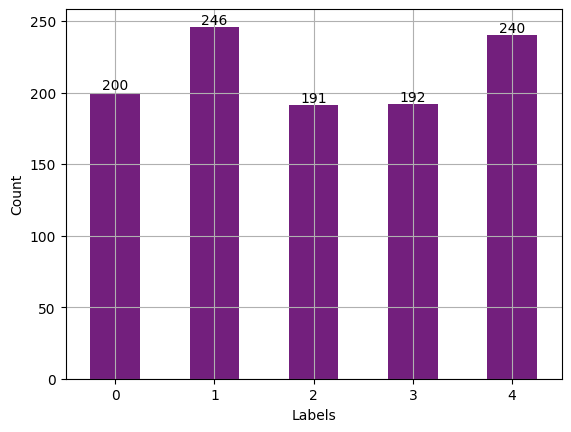

In [ ]:
value_counts = y_train['Label'].value_counts().sort_index()
value_counts.plot(kind='bar', color='#731F7D')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=0)
for index, value in enumerate(value_counts):
    plt.text(index, value, str(value), ha='center', va='bottom')
plt.grid(None)
plt.show()

Dane są w miarę równomiernie rozłożone, mamy porównywalne ilości rekordów z każdej kategorii.

Sprawdźmy teraz, jakie są najczęściej występujące w naszych danych słowa:

In [ ]:
words = df['Text'].apply(word_tokenize).sum()
word_counts = Counter(words)
most_common_words = word_counts.most_common(20)

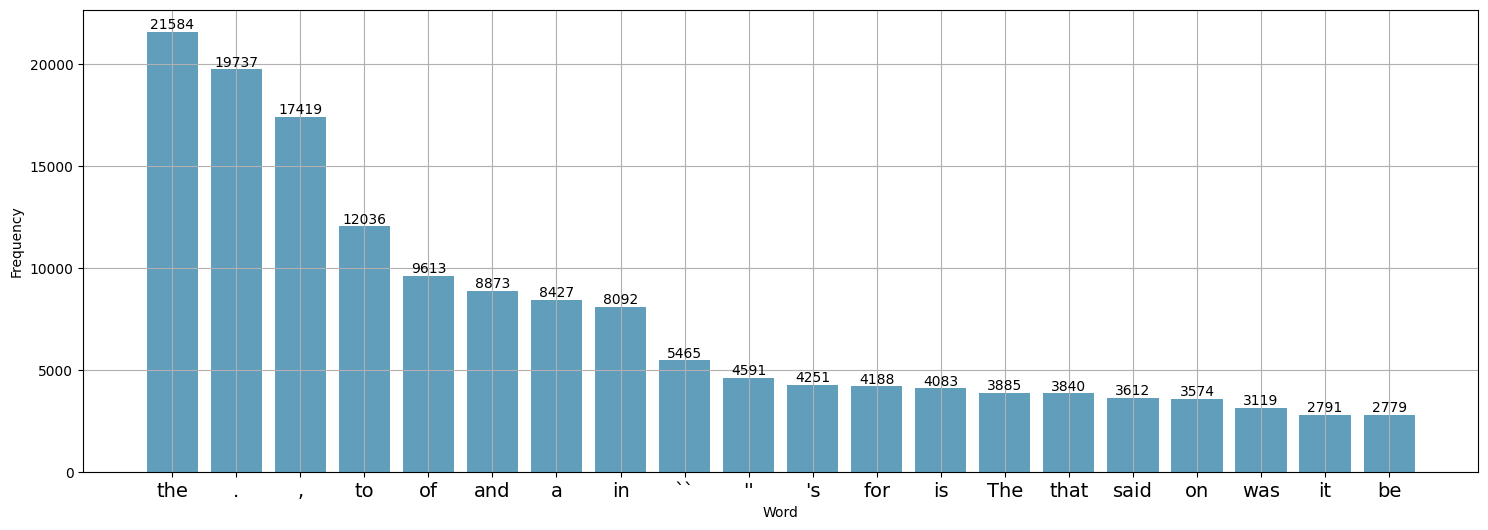

In [ ]:
words, counts = zip(*most_common_words)
plt.figure(figsize=(18, 6))
plt.bar(words, counts, color='#609ebc')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=0, fontsize=14)

for i in range(len(counts)):
    plt.text(i, counts[i], str(counts[i]), ha='center', va='bottom', fontsize=10)
plt.grid(None)
plt.show()

Jak widać, najczęściej występujące słowa to tzw. stopwords - to słowa, które często występują w języku (w naszym przypadku angielskim), ale nie niosą za sobą znaczenia (przykłady poniżej). Docelowo będziemy chciały usunąć te słowa z naszych danych, aby skupić się na tych, które mają większą wartość semantyczną i pozwolą nam na późniejszą klasyfikację tekstów do odpowiednich kategorii.

In [ ]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

Zdefiniujmy funkcję, która wyczyści tekst ze stopwordsów oraz znaków numerycznych - otrzymamy tylko istotne semantycznie słowa. Ponadto zastąpi wszystkie wielkie litery małymi:

In [ ]:
def clean_text(text):
    stopwords_set = set(stopwords.words('english'))
    tokens = word_tokenize(text.lower())
    words = [word for word in tokens if word.isalpha() and word not in stopwords_set]
    return words

Zobaczymy teraz na wykresie, jakie są najczęściej występujące słowa w całym zbiorze danych:

In [ ]:
words = X_train['Text'].apply(clean_text).sum()
word_counts = Counter(words)
most_common_words = word_counts.most_common(20)

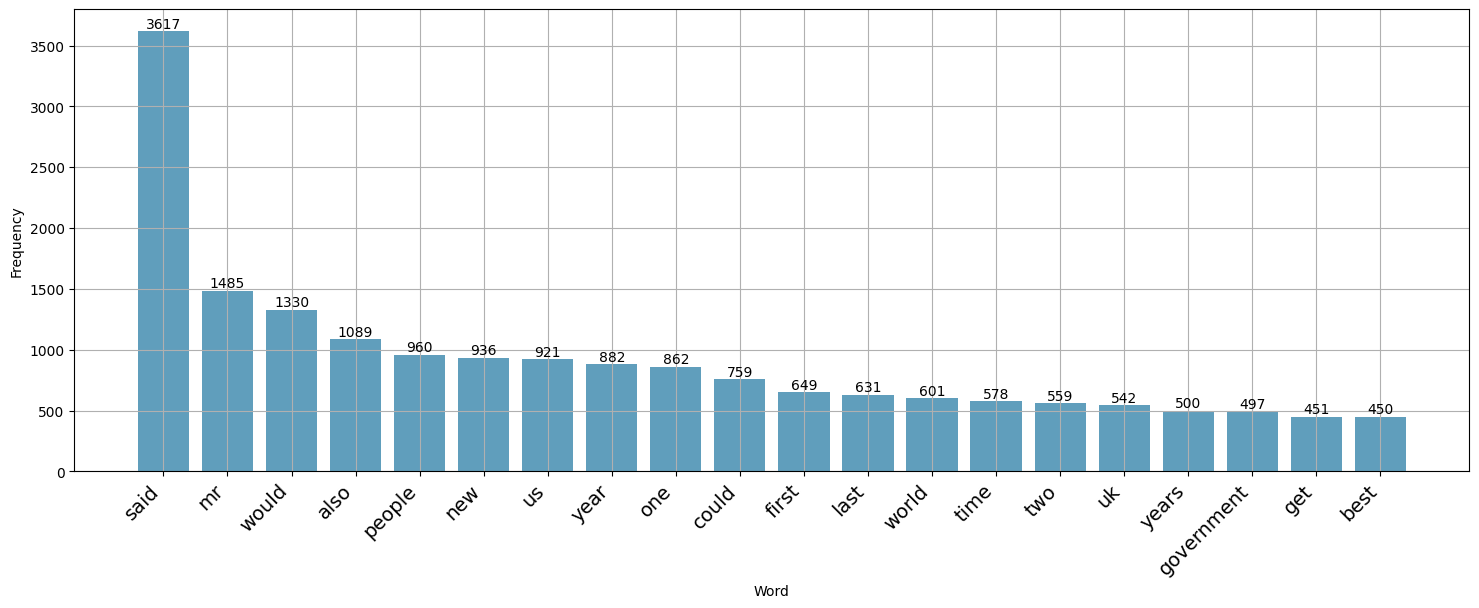

In [ ]:
words, counts = zip(*most_common_words)
plt.figure(figsize=(18, 6))
plt.bar(words, counts, color='#609ebc')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45, fontsize=14, ha='right')

for i in range(len(counts)):
    plt.text(i, counts[i], str(counts[i]), ha='center', va='bottom', fontsize=10)
plt.grid(None)
plt.show()

Dodajmy do naszej ramki danych kolumnę z wyczyszczonymi tekstami jako jeden string.

In [ ]:
df['Cleaned_text'] = df['Text'].apply(lambda x: ' '.join(clean_text(x)))

In [ ]:
df.head()

,Text,Label,Cleaned_text
0,Double eviction from Big Brother\n \n Model Ca...,3,double eviction big brother model caprice holb...
1,Ailing EuroDisney vows turnaround\n \n EuroDis...,4,ailing eurodisney vows turnaround eurodisney e...
2,Japanese growth grinds to a halt\n \n Growth i...,4,japanese growth grinds halt growth japan evapo...
3,Small firms 'hit by rising costs'\n \n Rising ...,4,small firms rising rising fuel materials costs...
4,Mexicans tracking unhappy Juninho\n \n Mexican...,1,mexicans tracking unhappy juninho mexican outf...


Wyczyścimy teraz dane z poszczególnych kategorii i sprawdzimy na wykresie, jak rozkładają się najczęściej występujące słowa:

In [ ]:
for i in range(5):
    temp = df.loc[df['Label'] == i]
    words = temp['Text'].apply(clean_text).sum()
    word_counts = Counter(words)
    most_common_words = word_counts.most_common(10)
    print('label:', i, 'words:', [most_common_words[j][0] for j in range(len(most_common_words))])

label: 0 words: ['said', 'mr', 'would', 'labour', 'government', 'people', 'election', 'blair', 'party', 'also']
label: 1 words: ['said', 'england', 'game', 'would', 'first', 'win', 'world', 'last', 'one', 'time']
label: 2 words: ['said', 'people', 'mr', 'also', 'would', 'could', 'one', 'new', 'technology', 'music']
label: 3 words: ['said', 'film', 'best', 'also', 'one', 'year', 'new', 'us', 'music', 'awards']
label: 4 words: ['said', 'us', 'mr', 'year', 'would', 'new', 'company', 'also', 'growth', 'economy']


Zobaczmy, jak to wygląda na wykresach:

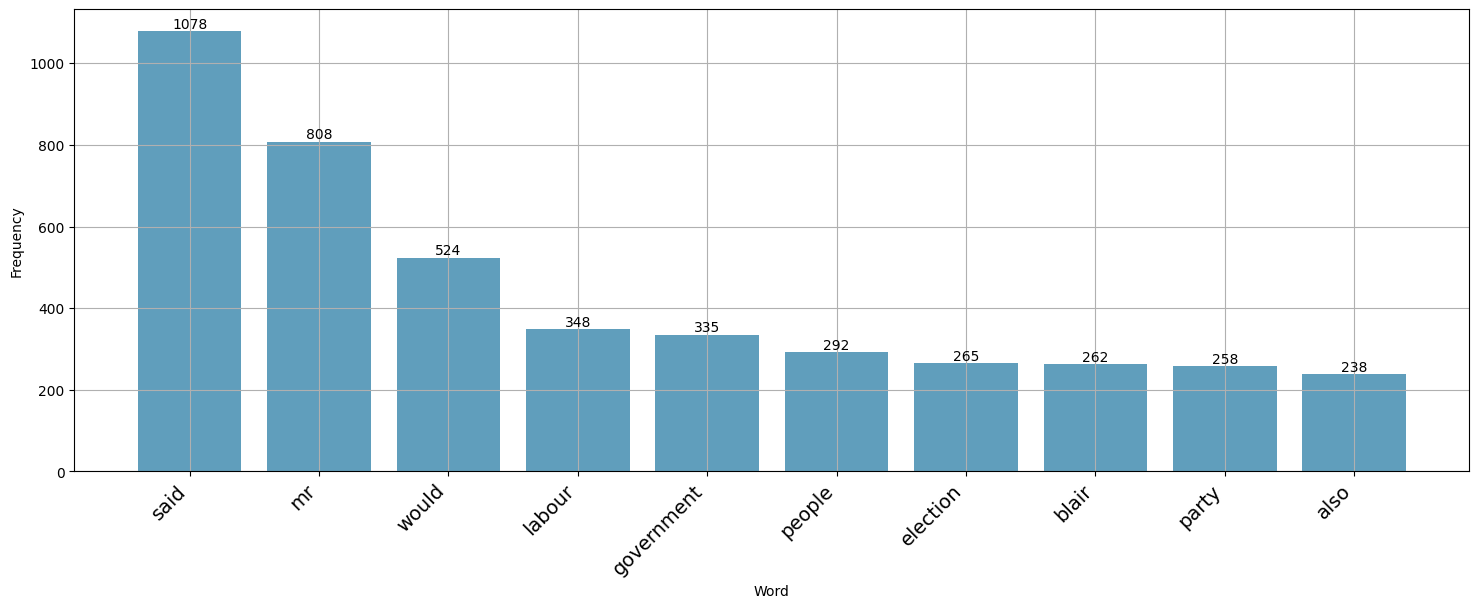

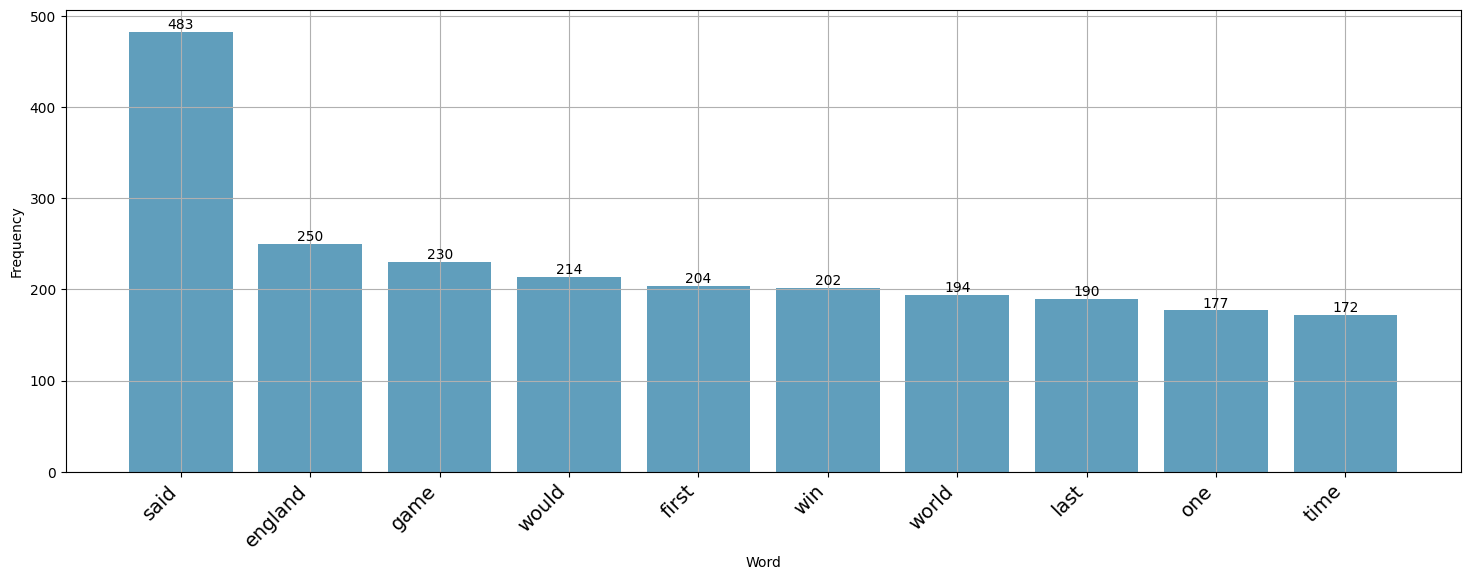

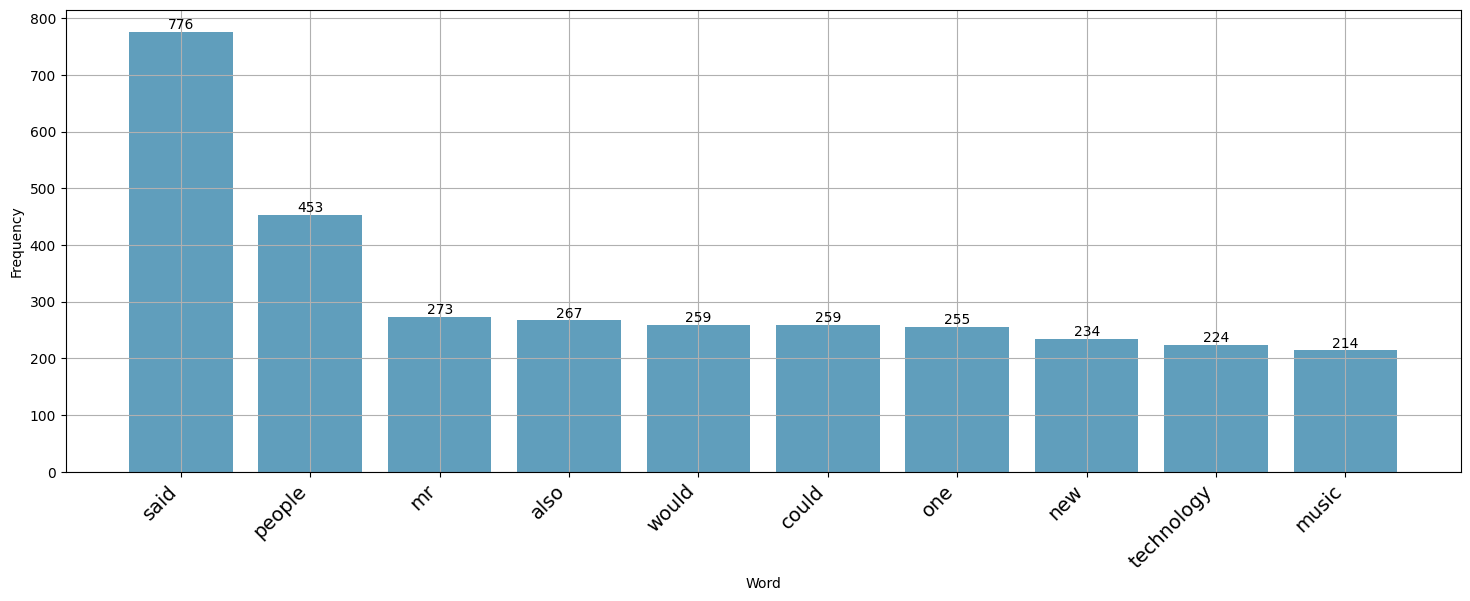

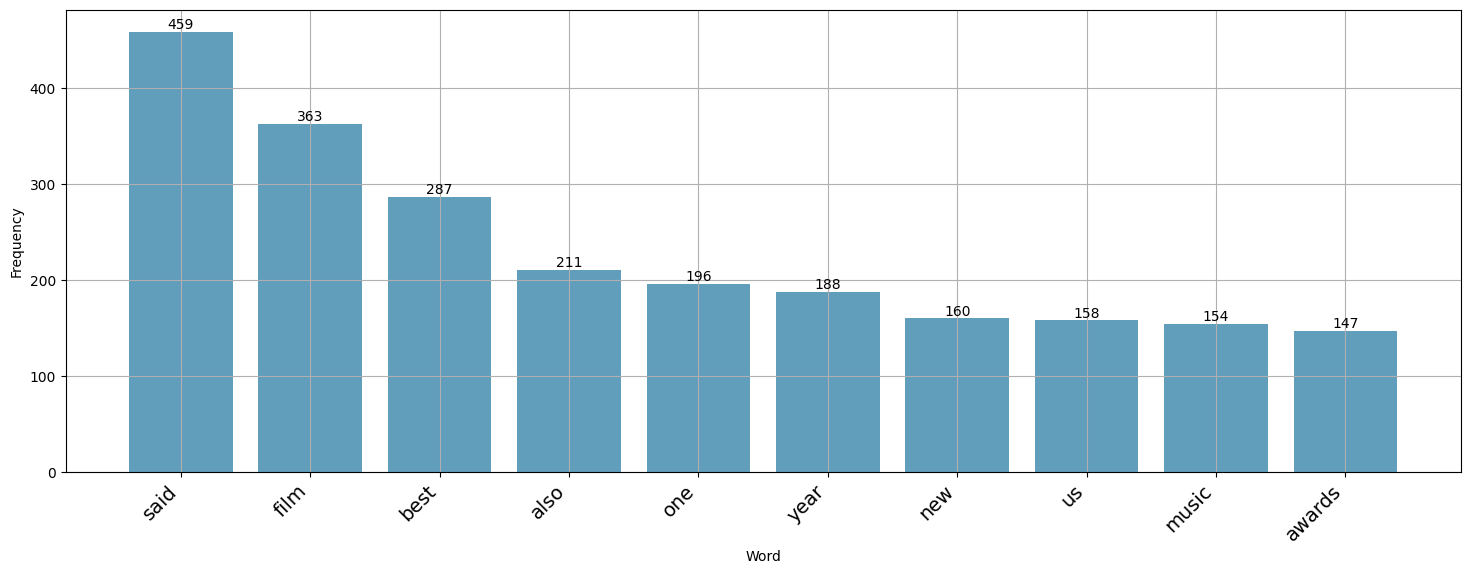

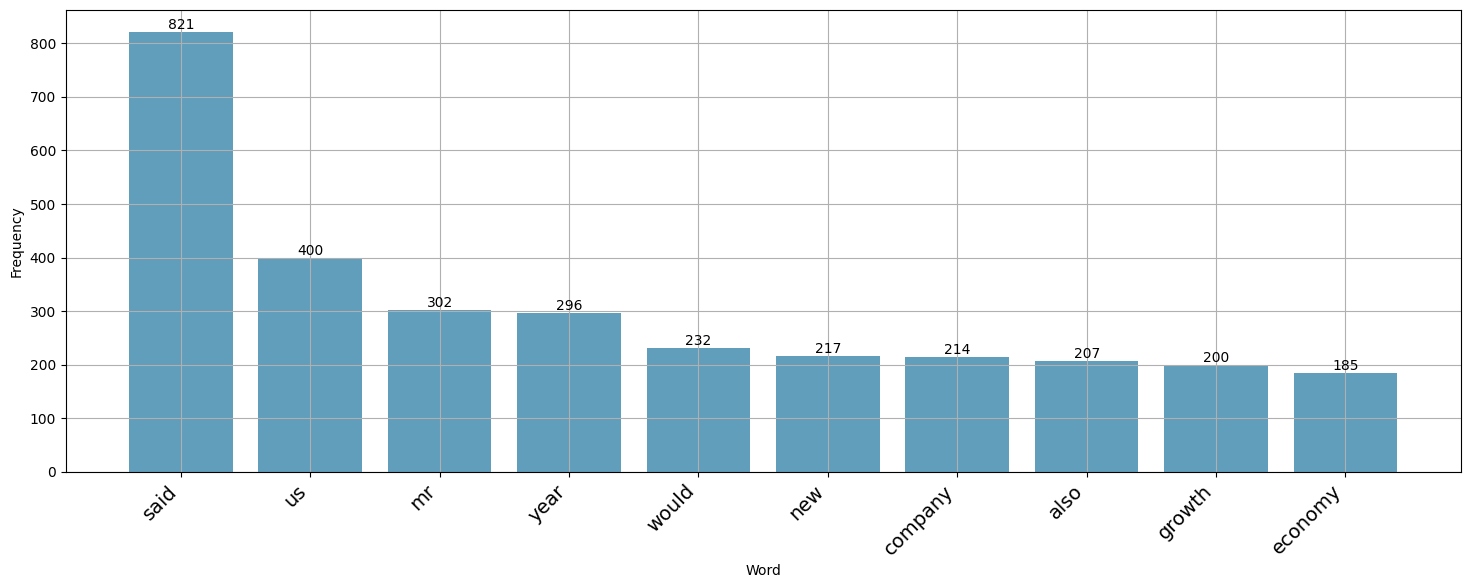

In [ ]:
for i in range(5):
    temp = df.loc[df['Label'] == i]
    words = temp['Text'].apply(clean_text).sum()
    word_counts = Counter(words)
    most_common_words = word_counts.most_common(10)
    words, counts = zip(*most_common_words)
    plt.figure(figsize=(18, 6))
    plt.bar(words, counts, color='#609ebc')
    plt.xlabel('Word')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, fontsize=14, ha='right')

    for j in range(len(counts)):
        plt.text(j, counts[j], str(counts[j]), ha='center', va='bottom', fontsize=10)
    plt.grid(None)
    plt.show()


#### <span style="color: purple;">3.3. Lematyzacja i dalsze czyszczenie tekstu</span>

<span style="color: purple;">Zajmijmy się teraz lematyzacją tekstu. Lematyzacja to zabieg polegający na sprowadzeniu różnych odmienionych form wyrazów do ich formy podstawowej - lematu. Ułatwi to późniejszą analizę i dalsze czyszczenie tekstu z wyrazów niekoniecznie istotnych semantycznie, a co za tym idzie - klasyfikacyjnie.</span>

<span style="color: purple;">Wyżej uzyskaliśmy już stokenizowany tekst. Zdefiniujmy funkcje, które pomogą nam go zlematyzować.</span>

In [ ]:
# Inicjalizacja lematyzatora
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    """Mapowanie tagów części mowy z biblioteki NLTK na format używany przez WordNetLemmatizer"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {
        "J": wordnet.ADJ,
        "N": wordnet.NOUN,
        "V": wordnet.VERB,
        "R": wordnet.ADV
    }
    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize_tokens(tokens):
    """Lematyzacja tokenów"""
    tokens = word_tokenize(tokens)
    lemmatized_tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens]
    return ' '.join(lemmatized_tokens)


<span style="color: purple;">Czas na lematyzację:</span>

In [ ]:
df['Lemmatized_text'] = df['Cleaned_text'].apply(lemmatize_tokens)

In [ ]:
df.head()

,Text,Label,Cleaned_text,Lemmatized_text
0,Double eviction from Big Brother\n \n Model Ca...,3,double eviction big brother model caprice holb...,double eviction big brother model caprice holb...
1,Ailing EuroDisney vows turnaround\n \n EuroDis...,4,ailing eurodisney vows turnaround eurodisney e...,ail eurodisney vow turnaround eurodisney europ...
2,Japanese growth grinds to a halt\n \n Growth i...,4,japanese growth grinds halt growth japan evapo...,japanese growth grind halt growth japan evapor...
3,Small firms 'hit by rising costs'\n \n Rising ...,4,small firms rising rising fuel materials costs...,small firm rise rise fuel material cost hit co...
4,Mexicans tracking unhappy Juninho\n \n Mexican...,1,mexicans tracking unhappy juninho mexican outf...,mexican track unhappy juninho mexican outfit r...


<span style="color: purple;">Widzimy już na próbce danych, że tekst został zlematyzowany poprawnie.</span>

<span style="color: purple;">Sprawdźmy jeszcze raz rozkład najczęściej pojawiających się słów w naszych danych, które ponownie czyścimy ze stopwordsów:</span>

In [ ]:
words = df['Lemmatized_text'].apply(clean_text).sum()
word_counts = Counter(words)
most_common_words = word_counts.most_common(20)

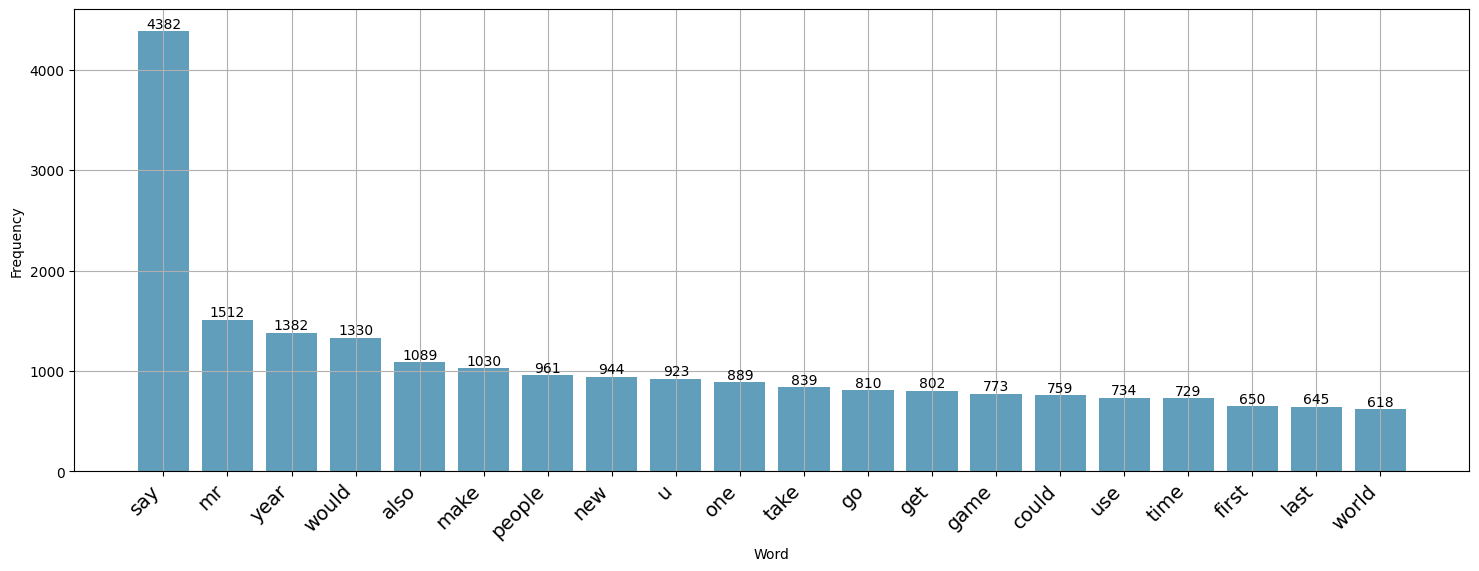

In [ ]:
words, counts = zip(*most_common_words)
plt.figure(figsize=(18, 6))
plt.bar(words, counts, color='#609ebc')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45, fontsize=14, ha='right')

for i in range(len(counts)):
    plt.text(i, counts[i], str(counts[i]), ha='center', va='bottom', fontsize=10)
plt.grid(None)
plt.show()

<span style="color: purple;">Widać, że wyniki się zmieniły. Na wykresie jednak nadal pozostały słowa, które raczej nie wniosą nic do klasyfiakcji tekstów. Przykładowo słowo 'say' w różnych formach używane było pewnie w większości artykułów informacyjnych. Zastanówmy się, czy da się w jakiś sposób wyczyścić tekst z nieistotnych semantycznie słów, które jednak nie są zawarte w liście angielskich stopwordsów.</span>

<span style="color: purple;">Po zgłębieniu tematu w źródłach doszłyśmy do wniosku, że na razie najłatwiej będzie ręcznie zmodyfikować listę stopwords na podstawie analizy najczęściej występujących słów. Dostępne w internecie gotowe rozszerzone listy stopwordsów zawierały słowa, które uznałyśmy za zbyt istotne w procesie klasyfikacji, żeby je usuwać.</span>

<span style="color: purple;">Zmodyfikujmy funkcję clean_text():</span>

In [ ]:
def clean_text(text):
    stopwords_set = set(stopwords.words('english'))
    stopwords_to_add = ['say', 'mr', 'would', 'also', 'u', 'could']
    stopwords_set.update(stopwords_to_add)
    tokens = word_tokenize(text.lower())
    words = [word for word in tokens if word.isalpha() and word not in stopwords_set]
    return words

<span style="color: purple;">Jeszcze raz sprawdźmy, które słowa występują najczęściej po wyczyszczeniu tekstu ze zbioru danych rozszerzonego o nasze stopwordsy:</span>

In [ ]:
words = df['Lemmatized_text'].apply(clean_text).sum()
word_counts = Counter(words)
most_common_words = word_counts.most_common(20)

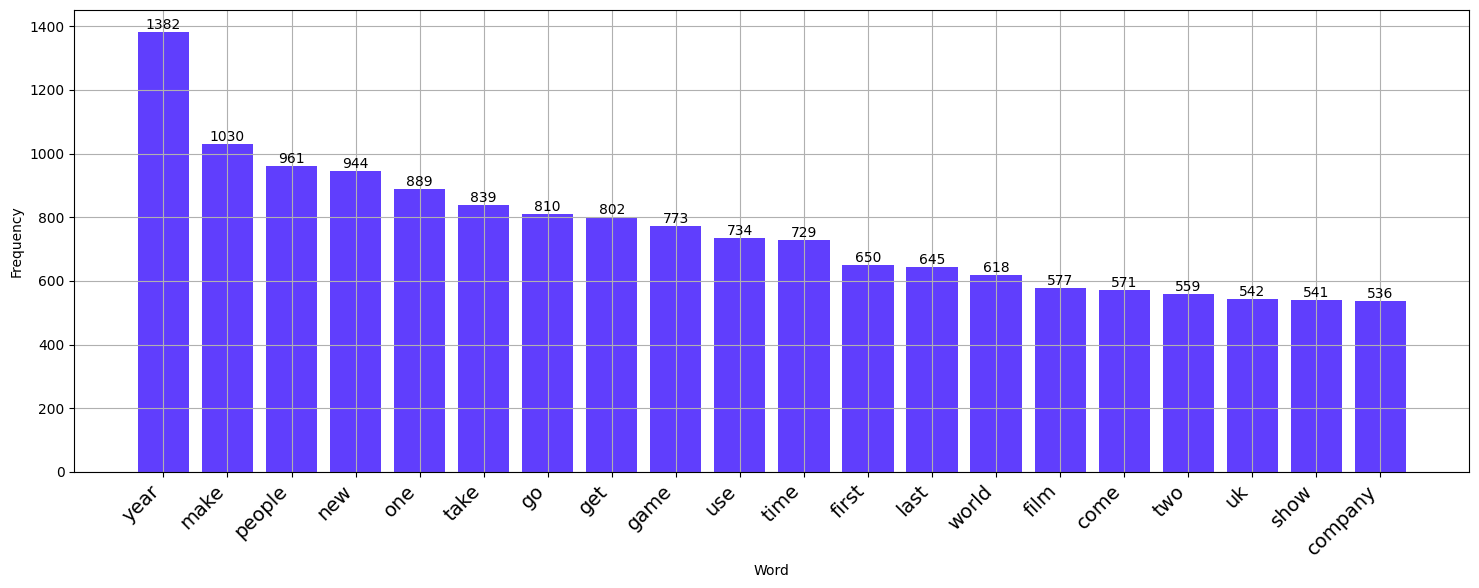

In [ ]:
words, counts = zip(*most_common_words)
plt.figure(figsize=(18, 6))
plt.bar(words, counts, color='#603efd')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45, fontsize=14, ha='right')

for i in range(len(counts)):
    plt.text(i, counts[i], str(counts[i]), ha='center', va='bottom', fontsize=10)
plt.grid(None)
plt.show()

<span style="color: purple;">Wygląda to lepiej. Nie usuwamy za dużo słów, bo pojedynczo nieistotne, w parach lub trójkach (jako elementy pewnych zwrotów), mogą być dużo bardziej istotne niż pojedynczo, a nie chcemy stracić danych.</span>

<span style="color: purple;">Sprawdźmy jeszcze dla poszczególnych kategorii:</span>

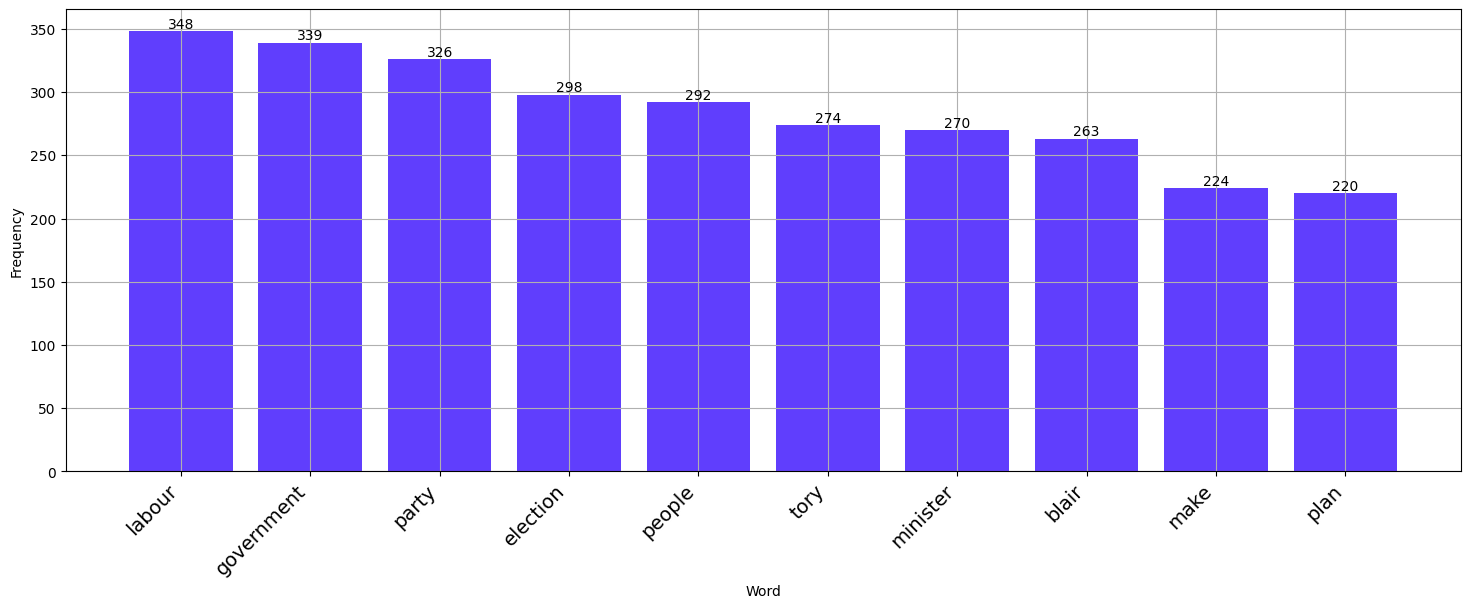

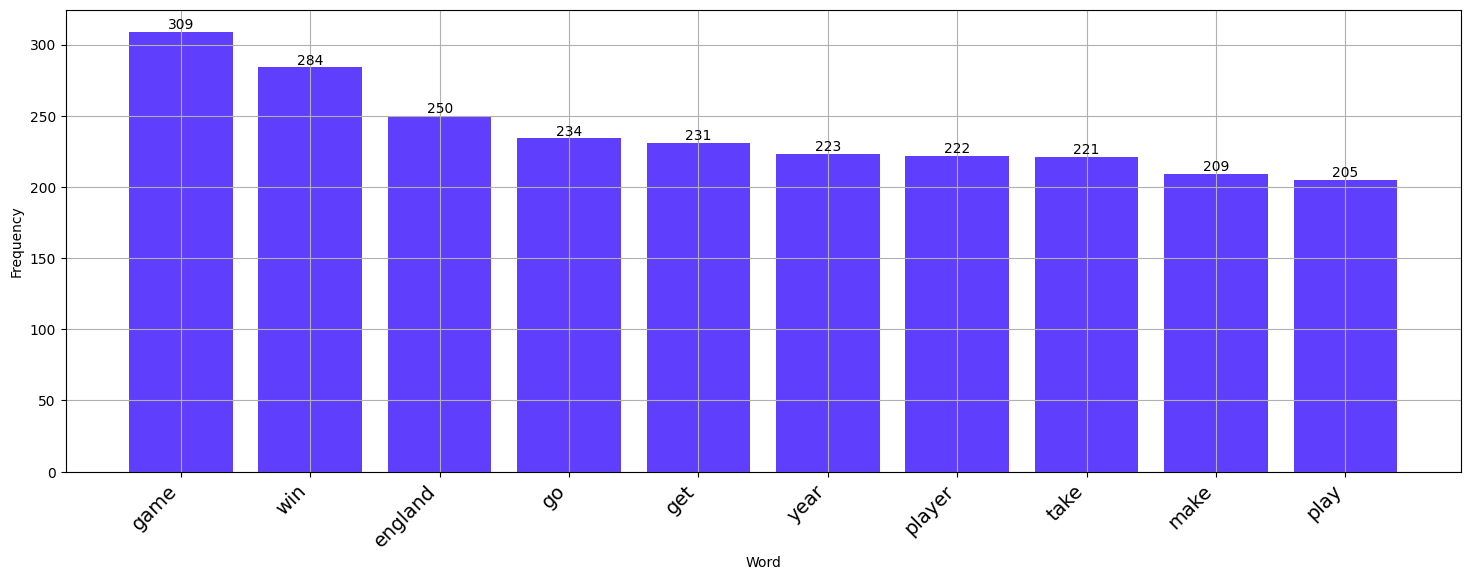

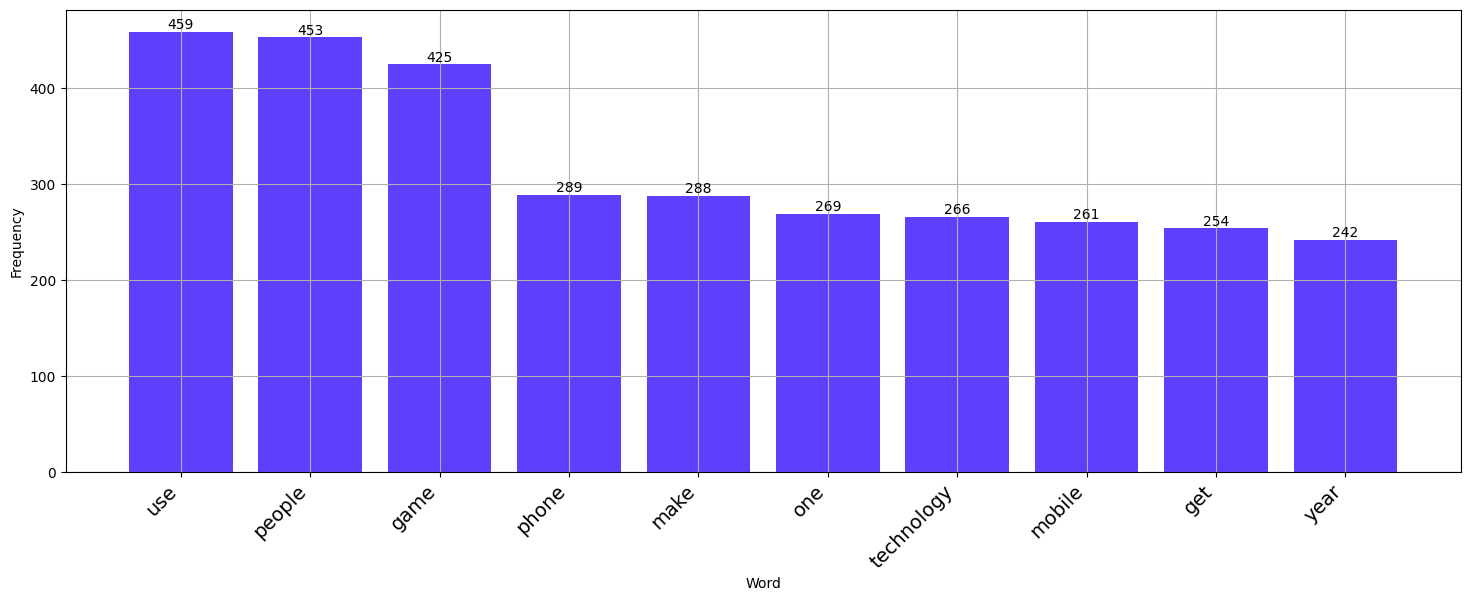

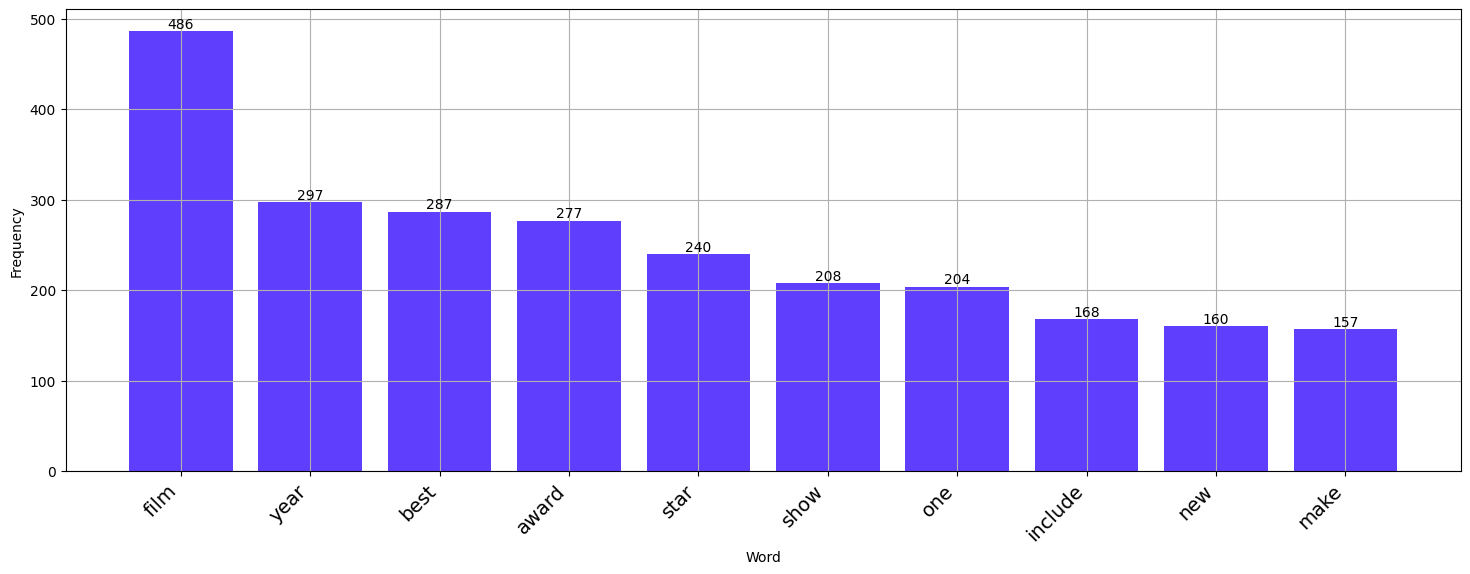

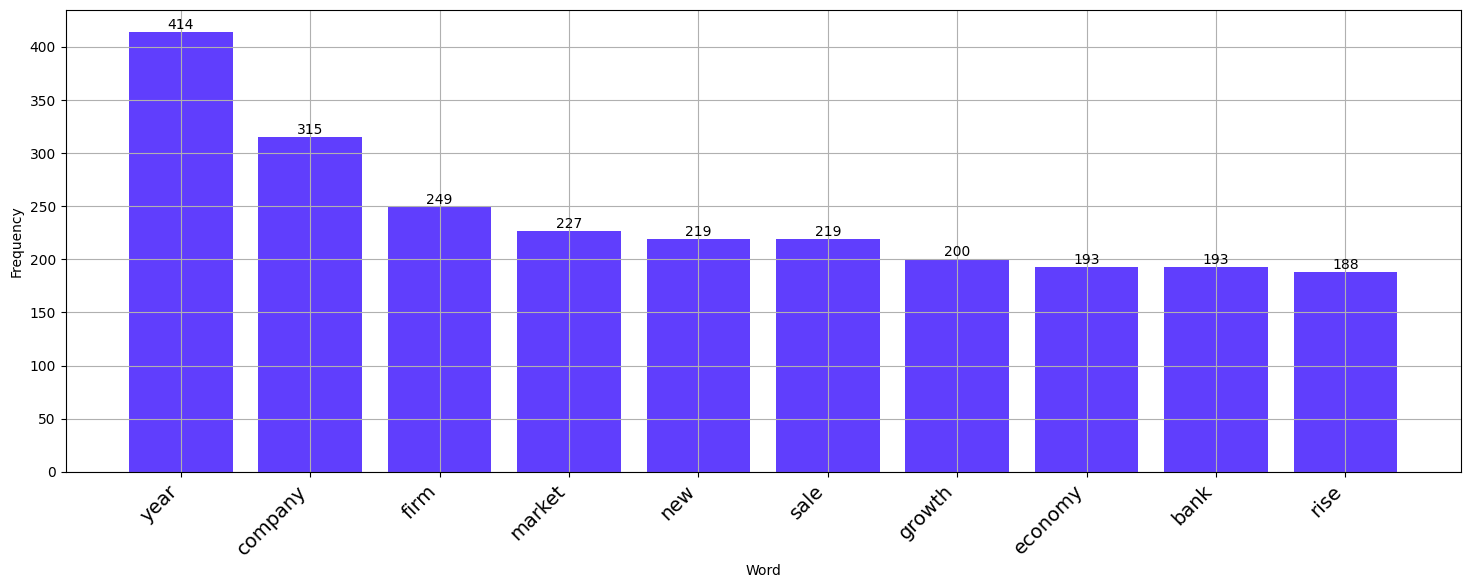

In [ ]:
for i in range(5):
    temp = df.loc[df['Label'] == i]
    words = temp['Lemmatized_text'].apply(clean_text).sum()
    word_counts = Counter(words)
    most_common_words = word_counts.most_common(10)
    words, counts = zip(*most_common_words)
    plt.figure(figsize=(18, 6))
    plt.bar(words, counts, color='#603efd')
    plt.xlabel('Word')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, fontsize=14, ha='right')

    for j in range(len(counts)):
        plt.text(j, counts[j], str(counts[j]), ha='center', va='bottom', fontsize=10)
    plt.grid(None)
    plt.show()

<span style="color: purple;">Najczęstsze słowa dla poszczególnych kategorii również wyglądają dużo lepiej. Na razie nie modyfikujemy funkcji dalej. Być może na dalszym etapie prac zdecydujemy się powrócić do tego zagadnienia.</span>

<span style="color: purple;">Na koniec jeszcze raz przeprowadźmy analizę występowania duplikatów w tekście:</span>

In [ ]:
duplicates = df[df.duplicated(subset='Lemmatized_text', keep='first')]
len(duplicates)

4

In [ ]:
df = df.drop_duplicates(subset='Lemmatized_text')
df = df.reset_index(drop=True)

In [ ]:
duplicates = df[df.duplicated(subset='Lemmatized_text', keep='first')]
len(duplicates)

0

### 4. Wizualizacja danych

#### 4.1. wordcloud

Dodatkową wizualizacją może być chmura słów, która pokaże nam, jakie słowa są najczęściej występujące w danych.

In [ ]:
colors = ["#62a8c3", "#4d1354", "#9c1a82"]
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)

Najpierw dla całego zestawu danych (z pominięciem słowa 'said'):

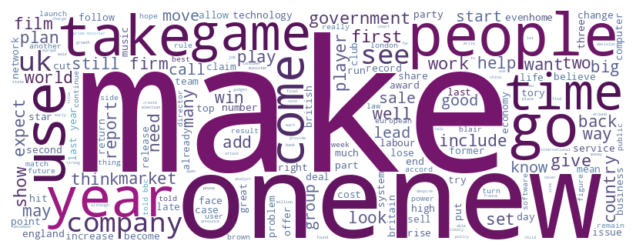

In [ ]:
cleaned_text = df['Lemmatized_text'].apply(clean_text).sum()
all_text = ' '.join(cleaned_text)

def remove_word(text, word):
    pattern = r'\b' + re.escape(word) + r'\b'
    cleaned_text = re.sub(pattern, '', text, flags=re.IGNORECASE)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    return cleaned_text

all_text = remove_word(all_text, 'said')
word_freq = Counter(re.findall(r'\b\w+\b', all_text.lower()))

def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    max_frequency = max(word_freq.values())
    min_frequency = min(word_freq.values())
    normalized_freq = (word_freq[word] - min_frequency) / (max_frequency - min_frequency)
    return mcolors.rgb2hex(cmap(normalized_freq))

wordcloud = WordCloud(width=800, height=300, background_color='white', color_func=color_func).generate(all_text)

plt.figure(figsize=(8, 3))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Następnie dla poszczególnych kategorii:

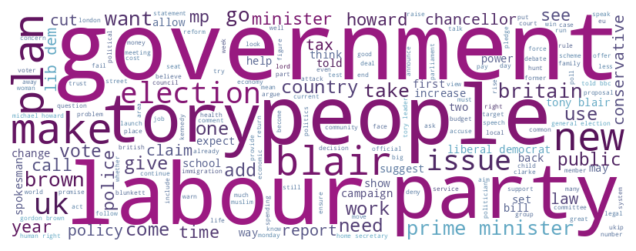

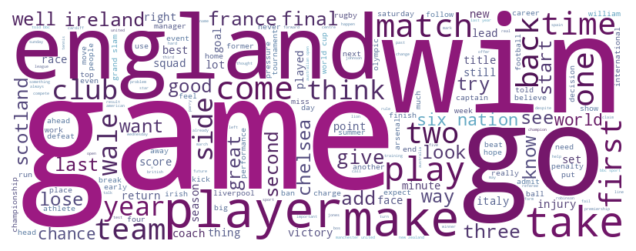

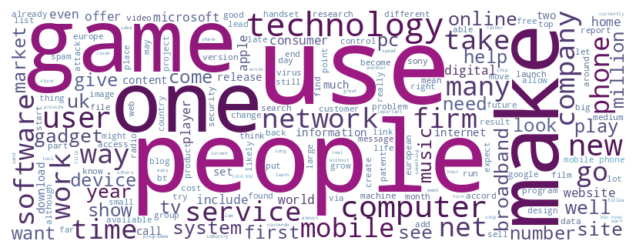

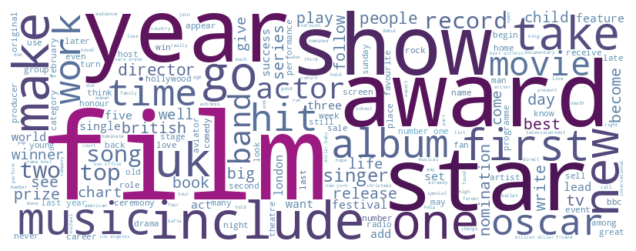

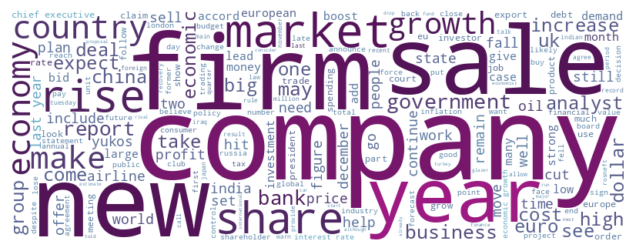

In [ ]:
for i in range(5):
    cleaned_text = df.loc[df['Label'] == i, 'Lemmatized_text'].apply(clean_text).sum()
    all_text = ' '.join(cleaned_text)
    all_text = remove_word(all_text, 'said')
    word_freq = Counter(re.findall(r'\b\w+\b', all_text.lower()))

    def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
        max_frequency = max(word_freq.values())
        min_frequency = min(word_freq.values())
        normalized_freq = (word_freq[word] - min_frequency) / (max_frequency - min_frequency)
        return mcolors.rgb2hex(cmap(normalized_freq))

    wordcloud = WordCloud(width=800, height=300, background_color='white', color_func=color_func).generate(all_text)
    plt.figure(figsize=(8, 3))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

#### 4.2. plotly

Zobaczmy, jak rozkłada się po 5 najczęstszych słów z każdej kategorii. W celu lepszej wizualizacji słów charakterystycznych dla danych etykiet usunęliśmy ręcznie słowa, które nie mają dużego wkładu semantycznego, a nie zostały wyłapane przez funkcje usuwające stopwords.

In [ ]:
results_df = pd.DataFrame()
for i in range(5):
    cleaned_text = df.loc[df['Label'] == i, 'Text'].apply(clean_text).sum()
    all_text = ' '.join(cleaned_text)
    # usuwamy słowa nieistotne semantycznie do klasyfikowania kategorii
    all_text = remove_word(all_text, 'said')
    all_text = remove_word(all_text, 'mr')
    all_text = remove_word(all_text, 'would')
    all_text = remove_word(all_text, 'could')
    all_text = remove_word(all_text, 'also')
    word_freq = Counter(re.findall(r'\b\w+\b', all_text.lower()))
    most_common_words = word_freq.most_common(5)
    word_freq_df = pd.DataFrame(most_common_words, columns=['word', 'count'])
    word_freq_df['label'] = i
    results_df = pd.concat([results_df, word_freq_df], ignore_index=True)
print(results_df)


          word  count  label
0       labour    348      0
1   government    335      0
2       people    292      0
3     election    265      0
4        blair    262      0
5      england    248      1
6         game    225      1
7        first    202      1
8          win    197      1
9        world    191      1
10      people    453      2
11         one    253      2
12         new    234      2
13  technology    218      2
14       music    214      2
15        film    363      3
16        best    287      3
17         one    196      3
18        year    188      3
19         new    160      3
20          us    400      4
21        year    296      4
22         new    217      4
23     company    214      4
24      growth    200      4


In [ ]:
fig = px.bar(results_df, x='label', y='count', color='word', text='word')
# # fig = px.bar(word_freq_df, x='word', y='count', title='Częstość występowania słów')
fig.show()

#### 4.3. scattertext

Stwórzmy jeszcze wykresy, które pomogą nam przeanalizować jakie słowa są wspólne dla różnych kategorii:

In [ ]:
# # ten kod działa, ale wywołuje się bardzo długo
# # otwierają się od razu pliki .html(), które mi się niestety nie załadowały - można próbować, ale nie gwarantuję sukcesu

# # Tworzenie obiektu Scattertext Corpus
# temp = df.copy()


# # Nowe wartości
# temp_labels = {0: 'Politics', 1: 'Sport', 2: 'Technology', 3: 'Entertainment', 4: 'Business'}

# # Podmiana wartości
# temp['Label'] = temp['Label'].replace(temp_labels)



# corpus = st.CorpusFromPandas(temp, category_col='Label', text_col='Text', nlp=st.whitespace_nlp_with_sentences).build()

# # Lista kategorii
# categories = temp['Label'].unique()
# print(categories)

# # Tworzenie wykresu dla każdej kategorii
# for category in categories:
#     html = st.produce_scattertext_explorer(
#         corpus,
#         category=category,  # Kategoria, która będzie wyróżniona
#         category_name=category,
#         not_category_name='Other Categories',
#         width_in_pixels=1000,
#         minimum_term_frequency=1,
#         pmi_threshold_coefficient=0
#     )

#     # Zapisanie wykresu do pliku HTML
#     file_name = f"scattertext_{category}.html"
#     open(file_name, "w").write(html)

#     # Otwieranie pliku w przeglądarce (opcjonalnie)
#     import webbrowser
#     webbrowser.open(file_name)


#### <span style="color: purple;">4.4. Analiza par i trójek słów</span>
<span style="color: purple;">Przeanalizujemy dodatkowo pary i trójki słów, które najczęściej występują razem w naszych danych. Najpierw jednak usuńmy z tekstu słowa, które nie niosą za sobą wartości semantycznej.</span>

In [ ]:
def remove_words(text, words):
    for word in words:
        pattern = r'\b' + re.escape(word) + r'\b'
        text = re.sub(pattern, '', text, flags=re.IGNORECASE)
        text = re.sub(r'\s+', ' ', text).strip()
    return text

words_to_remove = ['said', 'mr', 'would', 'could', 'also']
df['Text_with_removed_words'] = df['Cleaned_text'].apply(lambda x: ' '.join(remove_words(x, words_to_remove).split()))
df

,Text,Label,Cleaned_text,Lemmatized_text,Text_with_removed_words
0,Double eviction from Big Brother\n \n Model Ca...,3,double eviction big brother model caprice holb...,double eviction big brother model caprice holb...,double eviction big brother model caprice holb...
1,Ailing EuroDisney vows turnaround\n \n EuroDis...,4,ailing eurodisney vows turnaround eurodisney e...,ail eurodisney vow turnaround eurodisney europ...,ailing eurodisney vows turnaround eurodisney e...
2,Japanese growth grinds to a halt\n \n Growth i...,4,japanese growth grinds halt growth japan evapo...,japanese growth grind halt growth japan evapor...,japanese growth grinds halt growth japan evapo...
3,Small firms 'hit by rising costs'\n \n Rising ...,4,small firms rising rising fuel materials costs...,small firm rise rise fuel material cost hit co...,small firms rising rising fuel materials costs...
4,Mexicans tracking unhappy Juninho\n \n Mexican...,1,mexicans tracking unhappy juninho mexican outf...,mexican track unhappy juninho mexican outfit r...,mexicans tracking unhappy juninho mexican outf...
...,...,...,...,...,...
1060,Spears seeks aborted tour payment\n \n Singer ...,3,spears seeks aborted tour payment singer britn...,spear seek aborted tour payment singer britney...,spears seeks aborted tour payment singer britn...
1061,February poll claim 'speculation'\n \n Reports...,0,february poll claim reports tony blair plannin...,february poll claim report tony blair planning...,february poll claim reports tony blair plannin...
1062,Carry On star Patsy Rowlands dies\n \n Actress...,3,carry star patsy rowlands dies actress patsy r...,carry star patsy rowlands dy actress patsy row...,carry star patsy rowlands dies actress patsy r...
1063,Ferguson puts faith in youngsters\n \n Manches...,1,ferguson puts faith youngsters manchester unit...,ferguson put faith youngster manchester united...,ferguson puts faith youngsters manchester unit...


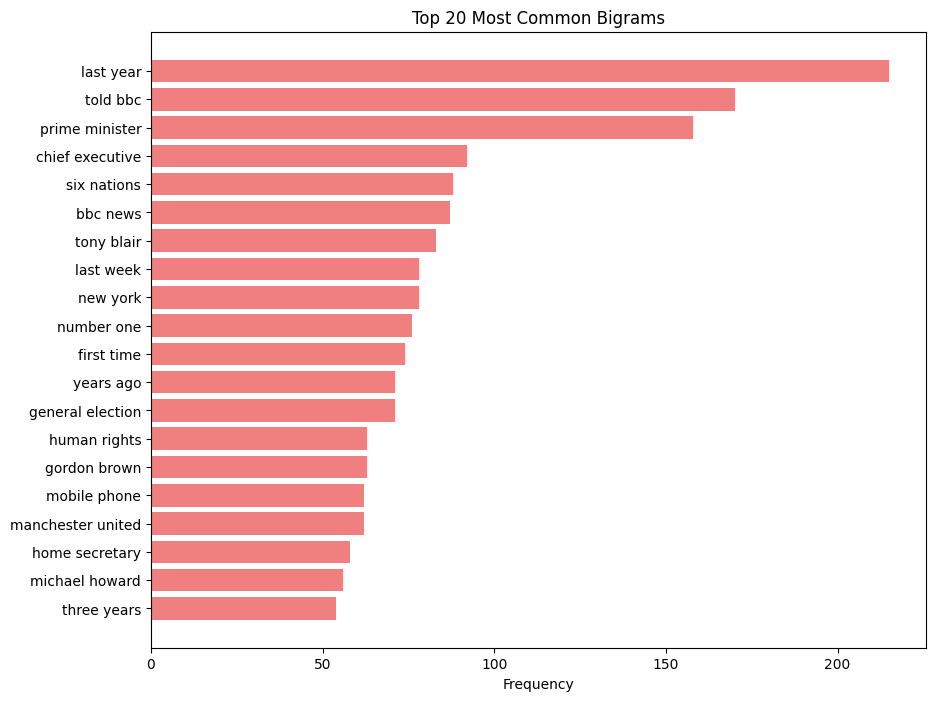

In [ ]:
# Bigrams
vectorizer = CountVectorizer(ngram_range=(2, 2))
X_bigrams = vectorizer.fit_transform(df['Text_with_removed_words'])
bigrams_freq = X_bigrams.sum(axis=0)
bigrams_freq_df = pd.DataFrame(bigrams_freq, columns=vectorizer.get_feature_names_out(), index=['frequency']).T
bigrams_freq_df = bigrams_freq_df.sort_values(by='frequency', ascending=False).head(20)

plt.figure(figsize=(10, 8))
plt.barh(bigrams_freq_df.index, bigrams_freq_df['frequency'], color='lightcoral')
plt.xlabel('Frequency')
plt.title('Top 20 Most Common Bigrams')
plt.gca().invert_yaxis()
plt.show()

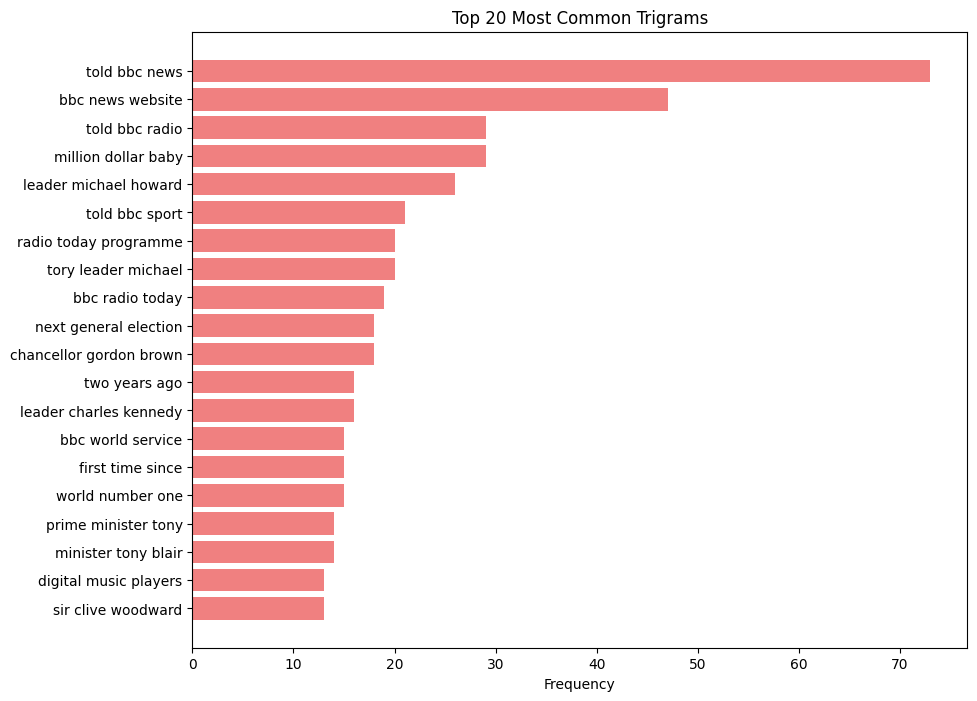

In [ ]:
# Trigrams
vectorizer = CountVectorizer(ngram_range=(3, 3))
X_trigrams = vectorizer.fit_transform(df['Text_with_removed_words'])
trigrams_freq = X_trigrams.sum(axis=0)
trigrams_freq_df = pd.DataFrame(trigrams_freq, columns=vectorizer.get_feature_names_out(), index=['frequency']).T
trigrams_freq_df = trigrams_freq_df.sort_values(by='frequency', ascending=False).head(20)

plt.figure(figsize=(10, 8))
plt.barh(trigrams_freq_df.index, trigrams_freq_df['frequency'], color='lightcoral')
plt.xlabel('Frequency')
plt.title('Top 20 Most Common Trigrams')
plt.gca().invert_yaxis()
plt.show()

### 5. Wnioski

- Dane, na których pracujemy, są pozbawione brakujących wartości, jednak zdarzają się duplikaty.
- W danych typu tekstowego występuje dużo fragmentów zupełnie nieistotnych semantycznie - są to tzw. stopwords, ale też symbole, znaki interpunkcyjne czy liczby.
- Niektóre najczęściej występujące słowa powtarzają się między kategoriami, jednak łatwo da się zauważyć takie, które mogą jednoznacznie wskazywać na konkretną tematykę tekstu.
- <span style="color: purple;">Lematyzacja słów i rozszerzenie listy stopwords na jej podstawie pomogły w jeszcze lepszym wyczyszczeniu tekstu.</span>
- <span style="color: purple;">Analiza par i trójek słów wskazuje na fakt, że pojedyncze słowo może nie być istotne semantycznie, ale występujące w otoczeniu innych (jako część zwrotów czy fraz) może nieść za sobą dość istotny przekaz.</span>